# GABLS experiments

In [1]:
using ClimaAnalysis 
using CairoMakie

import ClimaAtmos as CA

using Revise

includet("../post_processing/ci_plots.jl")

In [7]:
make_plots(Val{:gabls_test}(), "../output/gabls_test/output_active")

"../output/gabls_test/output_active/summary_3D.pdf"

In [11]:
# load files using ClimaAnalysis
resolutions = [10, 20, 30, 40, 60, 80, 100, 120, 150, 200, 300, 500]
function resolution_experiment_data(var, site; top = 4000.0, resolutions = resolutions)
    data = []
    for resolution in resolutions#, 80, 100, 120, 150, 200, 300, 500] 
        simdir = SimDir("output/gabls_test3/resolution_$resolution/output_active")
        da = get(simdir; short_name = var, reduction = "inst")
        da = window(da, "time", left = 6. * 3600.0, right = 9. *3600.0) # average 6 to 9 hours
        da = average_time(da)
        da = slice(da, x = 0, y = 0)
        da = window(da, "z", left = 0.0, right = top)
        from_grid = da.dims["z"]
        #interp_data = interp_vertical_prof(to_grid, from_grid, da.data)
        push!(data, da)

    end
    return data#transpose(hcat(data...))
end


resolution_experiment_data (generic function with 1 method)

In [36]:
length(profiles[1].dims["z"])

3

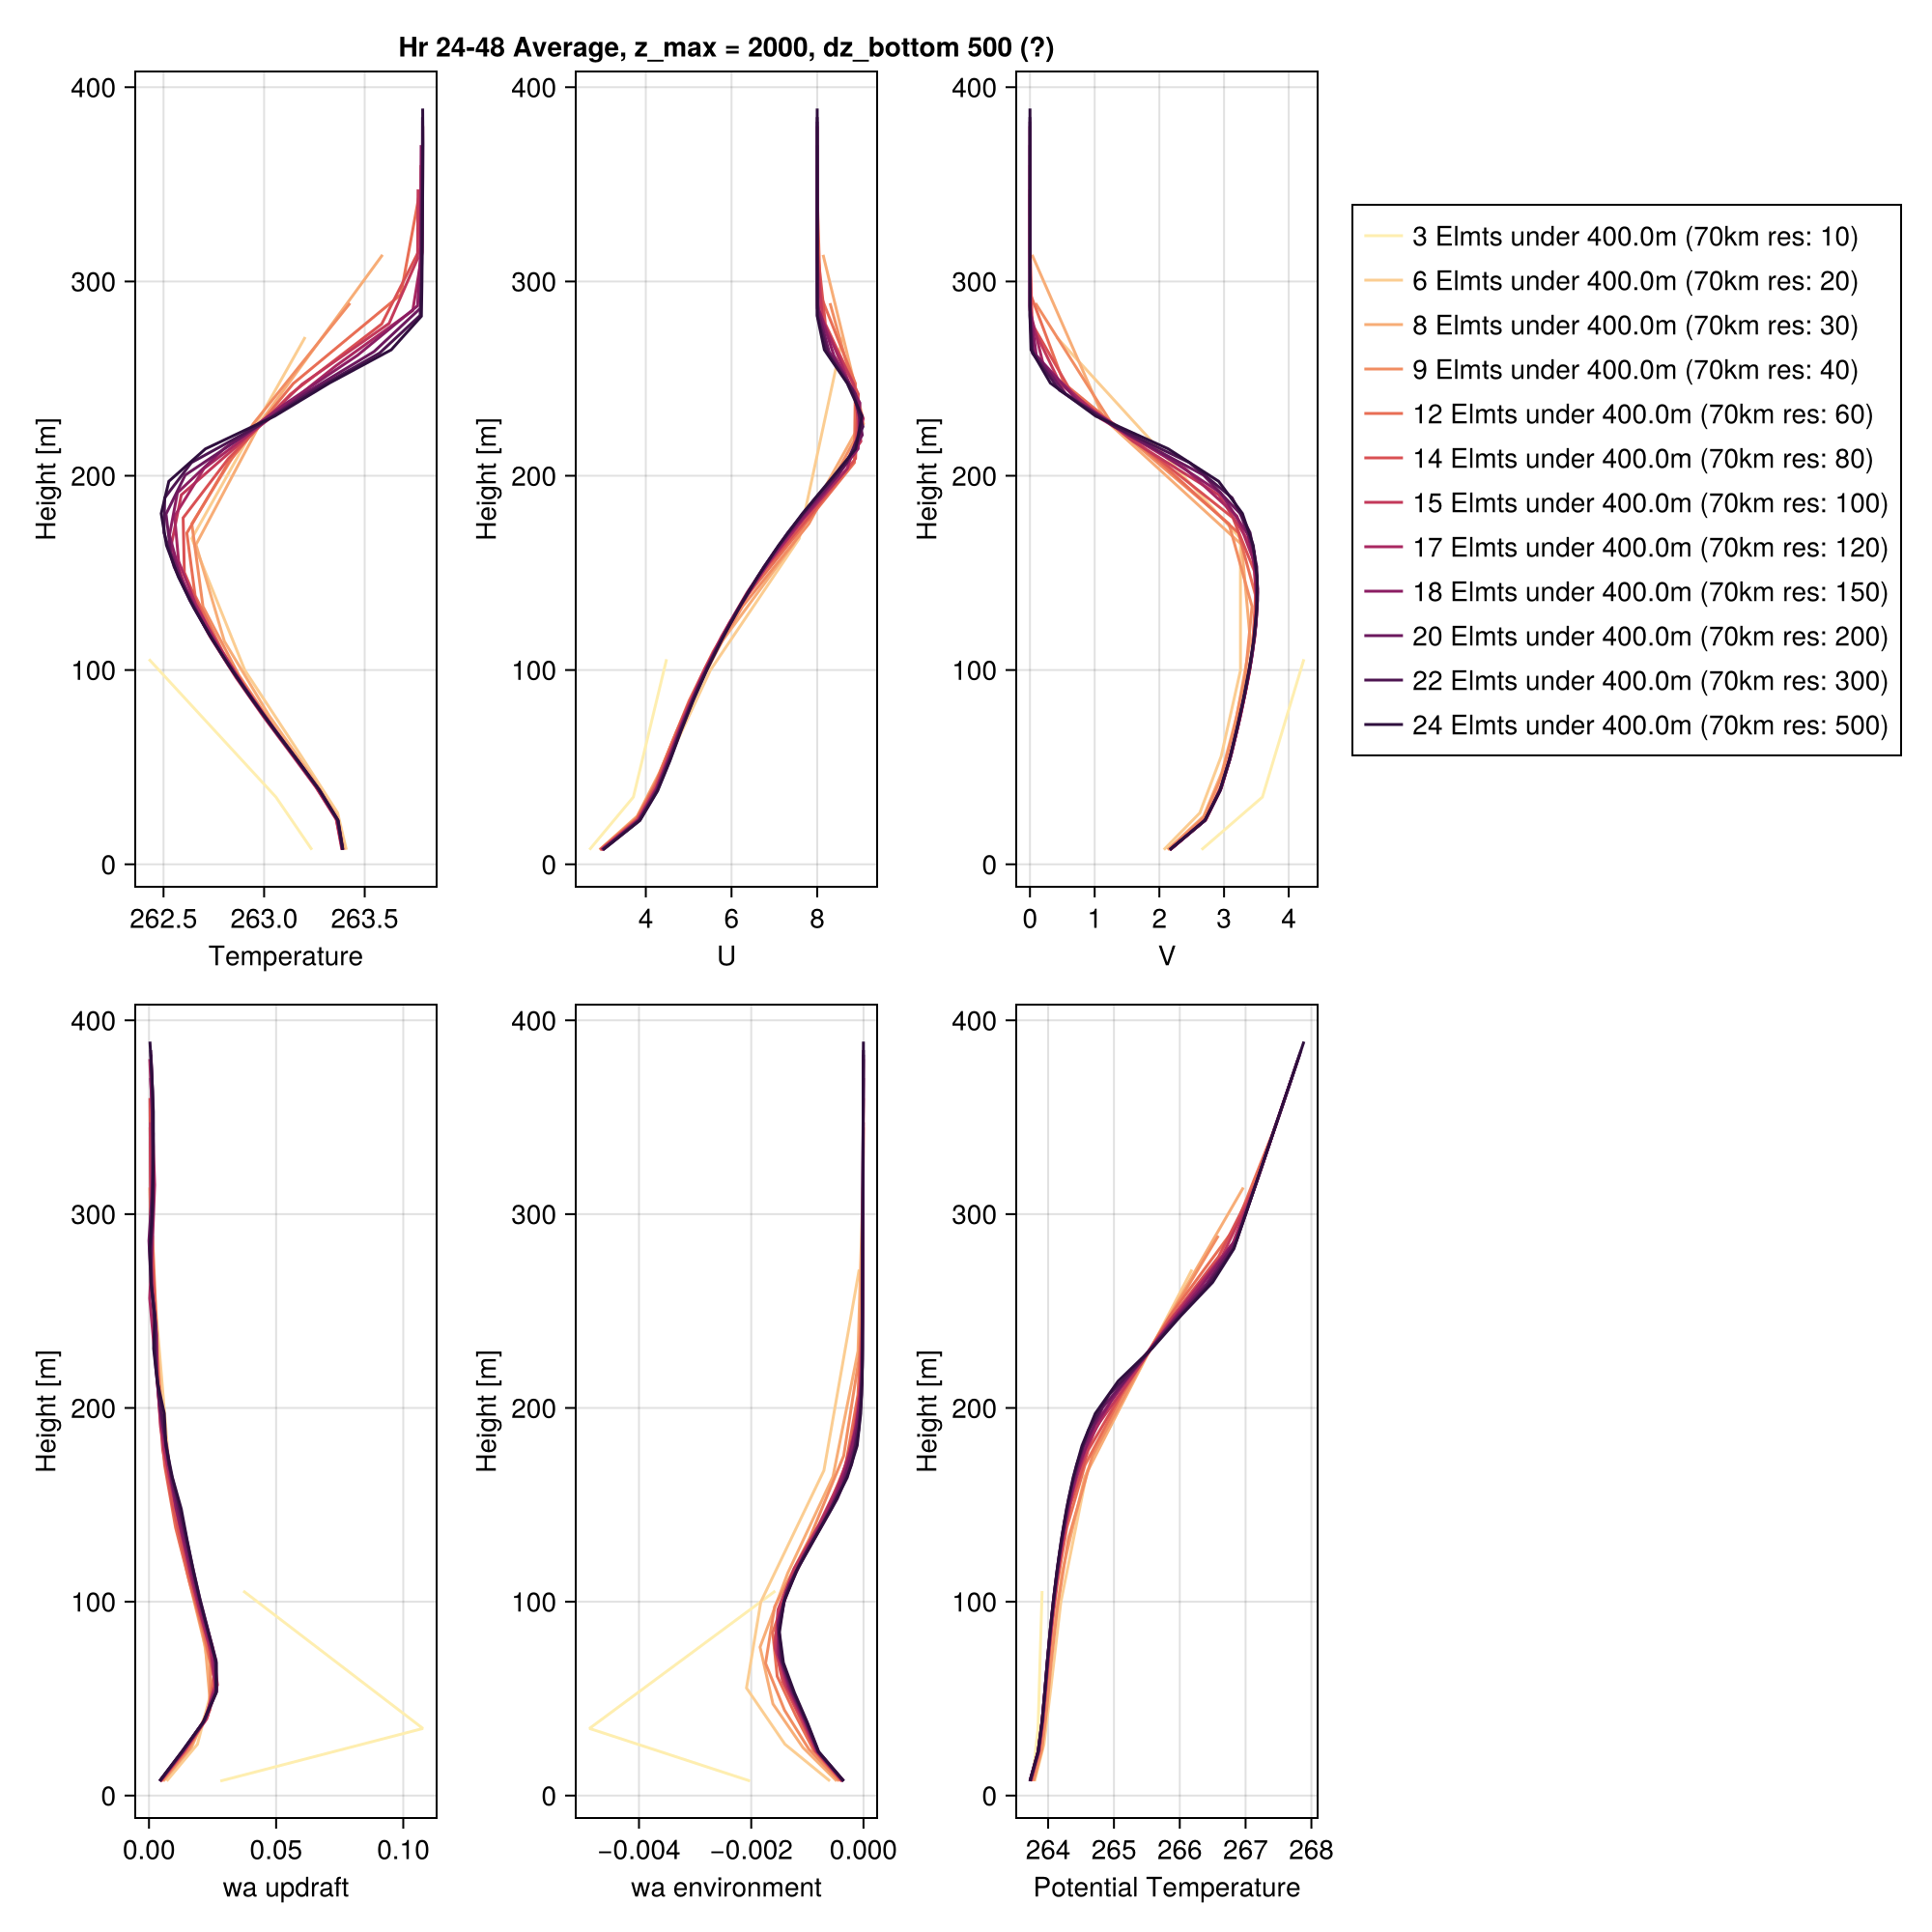

In [12]:
# plot 
fig = Figure(size = (1000, 1000))

height = 400.
profiles = resolution_experiment_data("ta", "gabls_test2", top = height)

ax = Axis(fig[1, 1], xlabel = "Temperature", ylabel = "Height [m]")
for i in 1:length(profiles)
    lines!(ax, profiles[i].data, profiles[i].dims["z"], label = "$(resolutions[i]) Vertical Elements", color = i, colormap = :matter, colorrange = (1, length(profiles)))
end

profiles = resolution_experiment_data("ua", "gabls_test2", top = height)

ax = Axis(fig[1, 2], xlabel = "U", ylabel = "Height [m]")
for i in 1:length(profiles)
    lines!(ax, profiles[i].data, profiles[i].dims["z"], label = "$(resolutions[i]) Vertical Elements", color = i, colormap = :matter, colorrange = (1, length(profiles)))
end

profiles = resolution_experiment_data("va", "gabls_test2", top = height)

ax = Axis(fig[1, 3], xlabel = "V", ylabel = "Height [m]")
for i in 1:length(profiles)
    lines!(ax, profiles[i].data, profiles[i].dims["z"], label = "$(length(profiles[i].dims["z"])) Elmts under $(height)m (70km res: $(resolutions[i]))", color = i, colormap = :matter, colorrange = (1, length(profiles)))
end
Legend(fig[1,4], ax)

profiles = resolution_experiment_data("waup", "gabls_test", top = height)
ax = Axis(fig[2, 1], xlabel = "wa updraft", ylabel = "Height [m]")
for i in 1:length(profiles)
    lines!(ax, profiles[i].data, profiles[i].dims["z"], label = "$(resolutions[i]) Vertical Elements", color = i, colormap = :matter, colorrange = (1, length(profiles)))
end

profiles = resolution_experiment_data("waen", "gabls_test", top = height)
ax = Axis(fig[2, 2], xlabel = "wa environment", ylabel = "Height [m]")
for i in 1:length(profiles)
    lines!(ax, profiles[i].data, profiles[i].dims["z"], label = "$(resolutions[i]) Vertical Elements", color = i, colormap = :matter, colorrange = (1, length(profiles)))
end

profiles = resolution_experiment_data("thetaa", "gabls_test", top = height)
ax = Axis(fig[2, 3], xlabel = "Potential Temperature", ylabel = "Height [m]")
for i in 1:length(profiles)
    lines!(ax, profiles[i].data, profiles[i].dims["z"], label = "$(resolutions[i]) Vertical Elements", color = i, colormap = :matter, colorrange = (1, length(profiles)))
end

Label(fig[1, 1:3, Top()], "Hr 24-48 Average, z_max = 2000, dz_bottom 500 (?)", valign = :bottom,
    font = :bold,
    padding = (0, 0, 5, 0))

# save figure 
save("output/gabls_test/gabls_resolution_experiment_3_hour6_9.png", fig)
fig

In [ ]:
function make_hybrid_spaces_truncated(
    h_space,
    z_max,
    z_elem,
    z_stretch;
    truncation = nothing,
    surface_warp = nothing,
    topo_smoothing = false,
    deep = false,
    parsed_args = nothing,
)
    FT = eltype(z_max)
    # TODO: change this to make_hybrid_grid
    h_grid = Spaces.grid(h_space)
    z_domain = Domains.IntervalDomain(
        Geometry.ZPoint(zero(z_max)),
        Geometry.ZPoint(z_max);
        boundary_names = (:bottom, :top),
    )
    z_domain2 = Domains.IntervalDomain(
        Geometry.ZPoint(zero(z_max)),
        Geometry.ZPoint(z_max);
        boundary_names = (:bottom, :top),
    )
    z_mesh = Meshes.IntervalMesh(z_domain, z_stretch; nelems = z_elem)
    
    @info "z heights" z_mesh.faces
    device = ClimaComms.device(h_space)
    z_topology = Topologies.IntervalTopology(
        ClimaComms.SingletonCommsContext(device),
        z_mesh,
    )
    z_grid = Grids.FiniteDifferenceGrid(z_topology)
    if isnothing(surface_warp)
        hypsography = Hypsography.Flat()
    else
        topo_smoothing = parsed_args["topo_smoothing"]
        z_surface = surface_warp(Fields.coordinate_field(h_space))
        if topo_smoothing
            Hypsography.diffuse_surface_elevation!(z_surface)
        end
        if parsed_args["mesh_warp_type"] == "SLEVE"
            @info "SLEVE mesh warp"
            hypsography = Hypsography.SLEVEAdaption(
                Geometry.ZPoint.(z_surface),
                FT(parsed_args["sleve_eta"]),
                FT(parsed_args["sleve_s"]),
            )
        elseif parsed_args["mesh_warp_type"] == "Linear"
            @info "Linear mesh warp"
            hypsography =
                Hypsography.LinearAdaption(Geometry.ZPoint.(z_surface))
        end
    end
    grid = Grids.ExtrudedFiniteDifferenceGrid(h_grid, z_grid, hypsography; deep)
    # TODO: return the grid
    center_space = Spaces.CenterExtrudedFiniteDifferenceSpace(grid)
    face_space = Spaces.FaceExtrudedFiniteDifferenceSpace(grid)
    return center_space, face_space
end

In [2]:
FT

UndefVarError: UndefVarError: `FT` not defined

In [5]:
using ClimaCore:Geometry,Domains, Meshes
FT = Float64


function get_truncated_grid(z_mesh, truncation)
    # set up domain for new grid
    z_domain_trunc = Domains.IntervalDomain(
        Geometry.ZPoint(zero(0.0)),
        Geometry.ZPoint(FT(truncation));
        boundary_names = (:bottom, :top),
    )

    # extract elements from original mesh and threshold below truncation
    grid_element_vec = Geometry.tofloat.(z_mesh.faces)
    grid_element_trunc_vec = filter(x -> x < FT(truncation), grid_element_vec)
    grid_element_trunc_zpt = Geometry.ZPoint.(grid_element_trunc_vec)

    # create new mesh
    mesh_trunc = Meshes.IntervalMesh(z_domain_trunc, grid_element_trunc_zpt)
end

# define original mesh on domain
z_domain = Domains.IntervalDomain(
    Geometry.ZPoint(zero(0.0)),
    Geometry.ZPoint(FT(4000.0));
    boundary_names = (:bottom, :top),
)

z_elem = 100
z_stretch = Meshes.HyperbolicTangentStretching(30.)
z_mesh = Meshes.IntervalMesh(z_domain, z_stretch; nelems = z_elem)


get_truncated_grid(z_mesh, 400.).faces


400.0


13-element Vector{ClimaCore.Geometry.ZPoint{Float64}}:
 ZPoint(0.0)
 ZPoint(30.000000000000693)
 ZPoint(60.24085299143111)
 ZPoint(90.72263588996287)
 ZPoint(121.44538184821974)
 ZPoint(152.4090795481512)
 ZPoint(183.61367250152892)
 ZPoint(215.05905835920115)
 ZPoint(246.74508822977037)
 ZPoint(278.6715660083732)
 ZPoint(310.8382477162186)
 ZPoint(343.24484085158866)
 ZPoint(375.89100375296704)

In [6]:
z_mesh.faces

101-element Vector{ClimaCore.Geometry.ZPoint{Float64}}:
 ZPoint(0.0)
 ZPoint(30.000000000000693)
 ZPoint(60.24085299143111)
 ZPoint(90.72263588996287)
 ZPoint(121.44538184821974)
 ZPoint(152.4090795481512)
 ZPoint(183.61367250152892)
 ZPoint(215.05905835920115)
 ZPoint(246.74508822977037)
 ZPoint(278.6715660083732)
 ⋮
 ZPoint(3632.4161376041525)
 ZPoint(3678.2897111376838)
 ZPoint(3724.1930197213737)
 ZPoint(3770.1218359469844)
 ZPoint(3816.0719229786428)
 ZPoint(3862.0390361127634)
 ZPoint(3908.0189243441523)
 ZPoint(3954.007331937068)
 ZPoint(4000.0)

In [69]:
using ClimaCore:Geometry,Domains, Meshes
z_max = 70000.
z_domain = Domains.IntervalDomain(
    Geometry.ZPoint(zero(z_max)),
    Geometry.ZPoint(z_max);
    boundary_names = (:bottom, :top),
)
z_domain_trunc = Domains.IntervalDomain(
    Geometry.ZPoint(zero(0.0)),
    Geometry.ZPoint(2000.);
    boundary_names = (:bottom, :top),
)

z_elem = 100
z_stretch = Meshes.HyperbolicTangentStretching(30.)
z_mesh = Meshes.IntervalMesh(z_domain, z_stretch; nelems = z_elem)

grid_element_vec = Geometry.tofloat.(z_mesh.faces)

# filter to below truncation threshold 
grid_element_trunc_vec = filter(x -> x < 2000., grid_element_vec)

grid_element_trunc_geo = Geometry.ZPoint.(grid_element_trunc_vec)
grid_element_trunc_geo

mesh2 = Meshes.IntervalMesh(z_domain_trunc, grid_element_trunc_geo)
mesh2

28-element IntervalMesh of IntervalDomain: z ∈ [0.0,2000.0] (:bottom, :top)

In [92]:
mesh2.faces

29-element Vector{ClimaCore.Geometry.ZPoint{Float64}}:
 ZPoint(0.0)
 ZPoint(30.000000000001137)
 ZPoint(61.71156020984281)
 ZPoint(95.23148523219672)
 ZPoint(130.66195557333793)
 ZPoint(168.11081447760336)
 ZPoint(207.6918686750895)
 ZPoint(249.52520354840192)
 ZPoint(293.7375132203823)
 ZPoint(340.4624460571004)
 ⋮
 ZPoint(1066.6242826204864)
 ZPoint(1157.0010450446377)
 ZPoint(1252.4486031942017)
 ZPoint(1353.24383283005)
 ZPoint(1459.6778382352281)
 ZPoint(1572.0565791857389)
 ZPoint(1690.701512980395)
 ZPoint(1815.950250197349)
 ZPoint(1948.1572225571608)

In [88]:
z_max = 38792.628763440676
z_domain = Domains.IntervalDomain(
    Geometry.ZPoint(zero(z_max)),
    Geometry.ZPoint(z_max);
    boundary_names = (:bottom, :top),
)

z_elem = 84
z_stretch = Meshes.HyperbolicTangentStretching(30.)
z_mesh = Meshes.IntervalMesh(z_domain, z_stretch; nelems = z_elem)

# filter(x -> x > 40000, Geometry.tofloat.(z_mesh.faces))
Geometry.tofloat.(z_mesh.faces)

85-element Vector{Float64}:
     0.0
    29.99999999999716
    61.84619831925979
    95.65055027438792
   131.5315885885825
   169.61478274755694
   210.03291448091238
   252.92646961659906
   298.4440464836318
   346.74278095206455
     ⋮
 29467.020832090227
 30596.17204699351
 31739.66858712266
 32895.65487661476
 34062.188453083654
 35237.252361477644
 36418.76864977657
 37604.6127823598
 38792.628763440676